# Tutorial on different filter types

In this tutorial, we are going to cover how to use `gcm-filters` for different filter types: 
* Filters with fixed filter length scale
* Filters with spatially-varying filter length scale
* Anisotropic filters
* Filters with fixed filtering factor

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

## Loading the data

In our example, we are going to use **NeverWorld2 data**, created by the [Ocean Eddy Climate Process Team](https://ocean-eddy-cpt.github.io/). NeverWorld2 is a regional **MOM6 simulation** in stacked shallow water mode, on a spherical grid. The data are stored in the cloud, on the [Open Storage Network (OSN)](https://www.openstoragenetwork.org/).

In [2]:
from intake import open_catalog
cat = open_catalog('catalog.yaml')
list(cat)

['neverworld_five_day_averages',
 'neverworld_quarter_degree_snapshots',
 'neverworld_quarter_degree_averages',
 'neverworld_quarter_degree_static',
 'neverworld_quarter_degree_stats',
 'neverworld_eighth_degree_snapshots',
 'neverworld_eighth_degree_averages',
 'neverworld_eighth_degree_static',
 'neverworld_eighth_degree_stats',
 'neverworld_sixteenth_degree_snapshots',
 'neverworld_sixteenth_degree_averages',
 'neverworld_sixteenth_degree_static',
 'neverworld_sixteenth_degree_stats']

In this example, we are working with 5-day averages from the 1/4 degree simulation. 

In [3]:
ds = cat['neverworld_quarter_degree_averages'].to_dask()
ds

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables: (12/33)
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    ...          ...
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static.nc
    filename:          averages_00030002.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             NeverWorld2

Our filters also need to know about the grid that the data live on. The grid variables are stored in a separate dataset.

In [4]:
ds_static = cat['neverworld_quarter_degree_static'].to_dask()
ds_static

<xarray.Dataset>
Dimensions:      (time: 1, xh: 240, xq: 241, yh: 560, yq: 561)
Coordinates:
  * time         (time) object 0001-01-01 00:00:00
  * xh           (xh) float64 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * xq           (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh           (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq           (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.5 69.75 70.0
Data variables: (12/21)
    Coriolis     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    area_t       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    area_u       (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    area_v       (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    depth_ocean  (yh, xh) float32 dask.array<chunksize=(560, 240), meta=np.ndarray>
    dxCu         (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    ...           ...
    geolon_u     (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    geolon_v     (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
    wet          (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    wet_c        (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    wet_u        (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    wet_v        (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
Attributes:
    filename:   static.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      NeverWorld2

## Filtering with fixed filter length scale

First, we filter our data with a **fixed filter length scale of 200 km**. That is, we use a filter that attempts to remove scales smaller than 200 km. 

In [5]:
filter_scale = 200000

To filter our NeverWorld2 data with fixed filter length scale, we will use the grid type `IRREGULAR_WITH_LAND`. This grid type and its associated Laplacian work for any grid with locally orthogonal coordinates. The Laplacian needs the following grid variables:

In [6]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

### Preparing the grid input variables

MOM6 uses an Arakawa C grid staggering of variables. In this tutorial, we will filter kinetic energy `KE`: a field that is defined at T-points (or tracer points). Note that the `IRREGULAR_WITH_LAND` could also be used to filter U-fields or V-fields on a C-grid (or to filter fields on a B-grid), but we would have to create the filter with different arguments for `wet_mask`, `dxw`, `dyw`, `dxs`, `dys`, `area`.

`wet_mask` and `area` we have directly available from our model output:

In [7]:
wet_mask = ds_static.wet
area = ds_static.area_t

For the remaining grid variables, recall the following conventions:

* `dxw` = x-spacing centered at western cell edge
* `dyw` = y-spacing centered at western cell edge
* `dxs` = x-spacing centered at southern cell edge
* `dys` = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [8]:
dxw = xr.DataArray(data=ds_static.dxCu.isel(xq=slice(0,-1)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=ds_static.dyCu.isel(xq=slice(0,-1)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=ds_static.dxCv.isel(yq=slice(0,-1)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=ds_static.dyCv.isel(yq=slice(0,-1)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))

For each grid variable in the cell above, we 1) removed the padding in the `xq` and `yq` dimensions (on the upper side) and 2) renamed the `xq` and `yq` dimensions so that all grid variables have the same dimensions: `xh`, `yh`. This is because, as of now, `gcm-filters` requires all input variables to have the same dimensions, even though the grid variables are assumed staggered. (This is something we would like to change in the future.)

Let's plot a summary of the grid variables that are inputs to our filter.

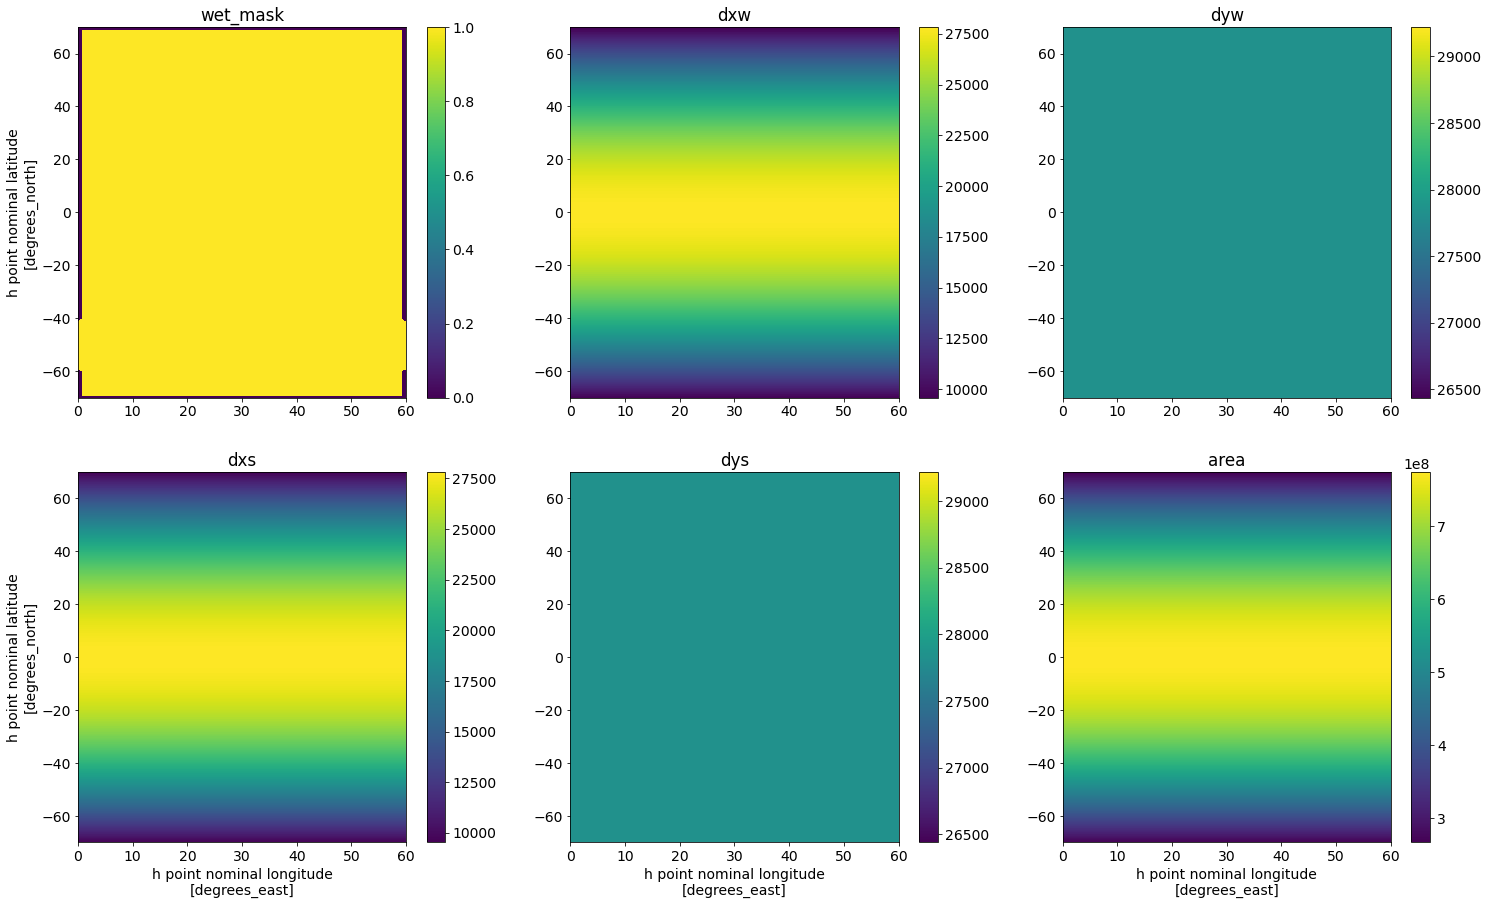

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'font.size': 14}
pylab.rcParams.update(params)

fig,axs = plt.subplots(2,3,figsize=(25,15))
wet_mask.plot(ax=axs[0,0], cbar_kwargs={'label': ''})
axs[0,0].set(title='wet_mask', xlabel='')
dxw.plot(ax=axs[0,1], cbar_kwargs={'label': ''})
axs[0,1].set(title='dxw', xlabel='', ylabel='')
dyw.plot(ax=axs[0,2], cbar_kwargs={'label': ''})
axs[0,2].set(title='dyw', xlabel='', ylabel='')
dxs.plot(ax=axs[1,0], cbar_kwargs={'label': ''})
axs[1,0].set(title='dxs')
dys.plot(ax=axs[1,1], cbar_kwargs={'label': ''})
axs[1,1].set(title='dys', ylabel='')
area.plot(ax=axs[1,2], cbar_kwargs={'label': ''})
axs[1,2].set(title='area', ylabel='');

The filter needs to know what the minimum grid spacing is in our model.

In [10]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(9518.17259783)

Finally, we have to set `kappa_w` and `kappa_s`. Since we don't want to vary the filter scale spatially, we set them equal to 1 over the full domain.

In [11]:
kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

### Filtering kinetic energy

We are now ready to create our filter. 

In [12]:
filter_200km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)
filter_200km

Filter(filter_scale=200000, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=24, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

We will apply the filter to `ds.KE`, which is a Dask array.

In [13]:
ds.KE

<xarray.DataArray 'KE' (time: 100, zl: 15, yh: 560, xh: 240)>
dask.array<open_dataset-a7ef50ac44a5e93fe2323e85364ad1edKE, shape=(100, 15, 560, 240), dtype=float32, chunksize=(10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Attributes:
    cell_measures:  area: area_t
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    long_name:      Layer kinetic energy per unit mass
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m2 s-2

Below, we will only be interested in plotting the filtered data from a single time slice and a single layer. We can therefore make things more efficient if we first rechunk our Dask array in such a way that each chunk contains only a 2D field.

In [14]:
ds['KE'] = ds['KE'].chunk({'time': 1, 'zl': 1})
ds.KE

,Array,Chunk
Bytes,806.40 MB,537.60 kB
Shape,"(100, 15, 560, 240)","(1, 1, 560, 240)"
Count,3011 Tasks,1500 Chunks
Type,float32,numpy.ndarray


We now apply our filter to our four-dimensional array. The filter acts only in the spatial dimensions `xh` and `yh`.

In [15]:
KE_filtered_to_200km = filter_200km.apply(ds.KE, dims=['yh', 'xh'])

Since we used a Dask array as an input, the filter operates lazily. The actual execution will happen next, when we plot the filtered field.

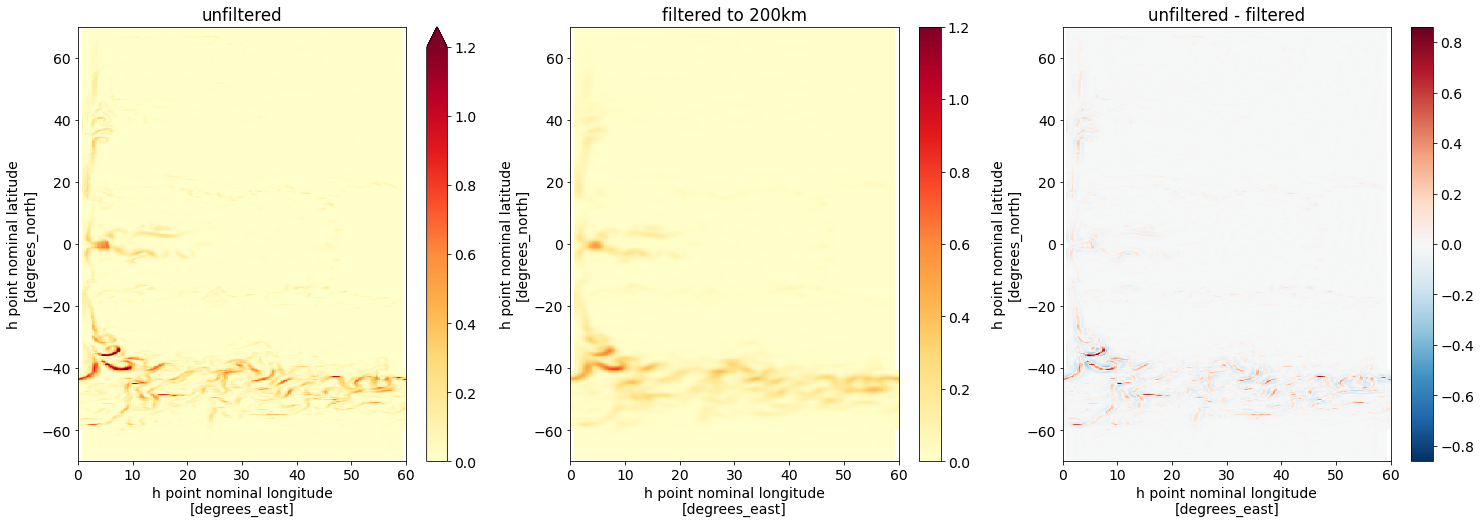

In [16]:
time = 0
layer = 0
vmin = 0
vmax = 1.2

fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.KE.isel(time=time, zl=layer).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd', cbar_kwargs={'label': ''}
)
axs[0].set_title('unfiltered')

KE_filtered_to_200km.isel(time=time, zl=layer).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd'
)
axs[1].set_title('filtered to 200km')

(ds.KE - KE_filtered_to_200km).isel(time=time, zl=layer).plot(
    ax=axs[2], 
    cmap='RdBu_r'
)
axs[2].set_title('unfiltered - filtered');

We observe the strongest smoothing at the high latitudes, in the ACC. This is because we used a filter with fixed filter scale. At high latitudes, the grid smalling is the smallest (scroll back up to our plots of `dxw` and `dxs`!) and the gap between the grid spacing and the filter scale is the largest.

## Filtering with spatially-varying filter scale
We now want to vary the filter scale over our NeverWorld2 domain. In this example, we define the local filter scale equal to the local **first baroclinic deformation radius** $L_d$, time-averaged over the length of our simulation.
Here is the time-averaged deformation radius.

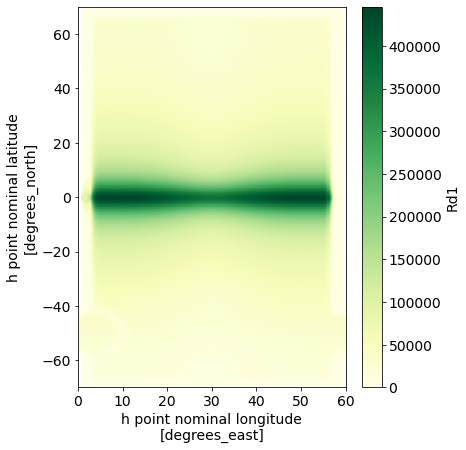

In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

ds['Rd1'].mean(dim='time').plot(figsize=(6,7), vmin=0, cmap='YlGn');

The maximum deformation radius is about 446 km:

In [18]:
L_max = ds['Rd1'].mean(dim='time').max(dim=['yh','xh']).values
L_max

array(445500.75, dtype=float32)

We set `filter_scale` equal to the largest desired filter scale in the domain, i.e., equal to the maximum deformation radius.

In [19]:
filter_scale = L_max

We now set the spatially varying $\kappa$ as
\begin{align*}
\kappa(x,y) = \frac{L_d(x,y)^2}{L_{max}^2}
\end{align*}

In [20]:
kappa = ds['Rd1'].mean(dim='time')**2 / L_max**2

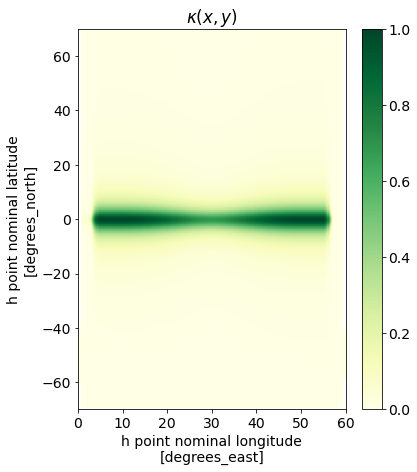

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,7))

kappa.plot(ax=ax, vmin=0, cmap='YlGn', cbar_kwargs={'label': ''})
ax.set(title=r'$\kappa(x,y)$');

Since we are still using the same grid as in the previous example, we can re-use our grid variables for `IRREGULAR_WITH_LAND`. 

In [22]:
filter_Ld = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa, 'kappa_s': kappa
    }
)
filter_Ld

Filter(filter_scale=array(445500.75, dtype=float32), dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=52, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

We apply the new filter to our kinetic energy field.

In [23]:
KE_filtered_to_Ld = filter_Ld.apply(ds.KE, dims=['yh', 'xh'])

Plotting the filtered field triggers the computation.

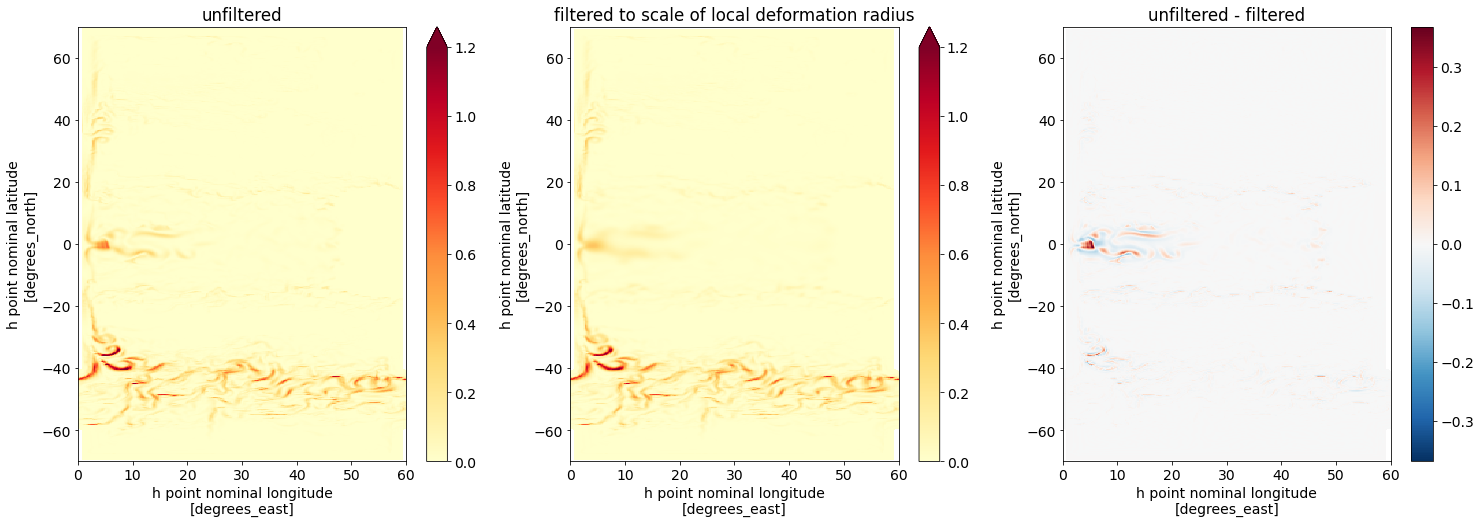

In [24]:
fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.KE.isel(time=time, zl=layer).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd',cbar_kwargs={'label': ''}
)
axs[0].set_title('unfiltered')

KE_filtered_to_Ld.isel(time=time, zl=layer).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd'
)
axs[1].set_title('filtered to scale of local deformation radius')

(ds.KE - KE_filtered_to_Ld).isel(time=time, zl=layer).plot(
    ax=axs[2], 
    cmap='RdBu_r'
)
axs[2].set_title('unfiltered - filtered');

In contrast to our previous example, the strongest smoothing occurs now close to the equator. This is because close to the equator, the local filter scale (i.e. the local deformation radius) is much larger than at high latitudes.

## Anisotropic filtering

Next, we want to use anisotropic filters that have different filter scales in the zonal and meridional directions. Note that zonal and meridional directions are aligned with our NeverWorld2 (spherical) grid directions.

The first anisotropic filter has a filter scale of **300 km in zonal direction**, and **30 km in meridional direction**. We will name this filter `filter_aniso_y`.

In [25]:
filter_scale = 300000
kappa_w = xr.ones_like(dxw)
kappa_s = 0.01 * xr.ones_like(dxs)

filter_aniso_y = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)
filter_aniso_y

Filter(filter_scale=300000, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=35, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

The second anisotropic filter has a filter scale of **30 km in zonal direction**, and **300 km in meridional direction**. We will name this filter `filter_aniso_x`.

In [26]:
filter_scale = 300000
kappa_w = 0.01 * xr.ones_like(dxw)
kappa_s = xr.ones_like(dxs)

filter_aniso_x = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)
filter_aniso_x

Filter(filter_scale=300000, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=35, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

We filter our kinetic energy field with both filters.

In [27]:
KE_filtered_aniso_y = filter_aniso_y.apply(ds.KE, dims=['yh', 'xh'])
KE_filtered_aniso_x = filter_aniso_x.apply(ds.KE, dims=['yh', 'xh'])

Here is the result of our two filtering operations.

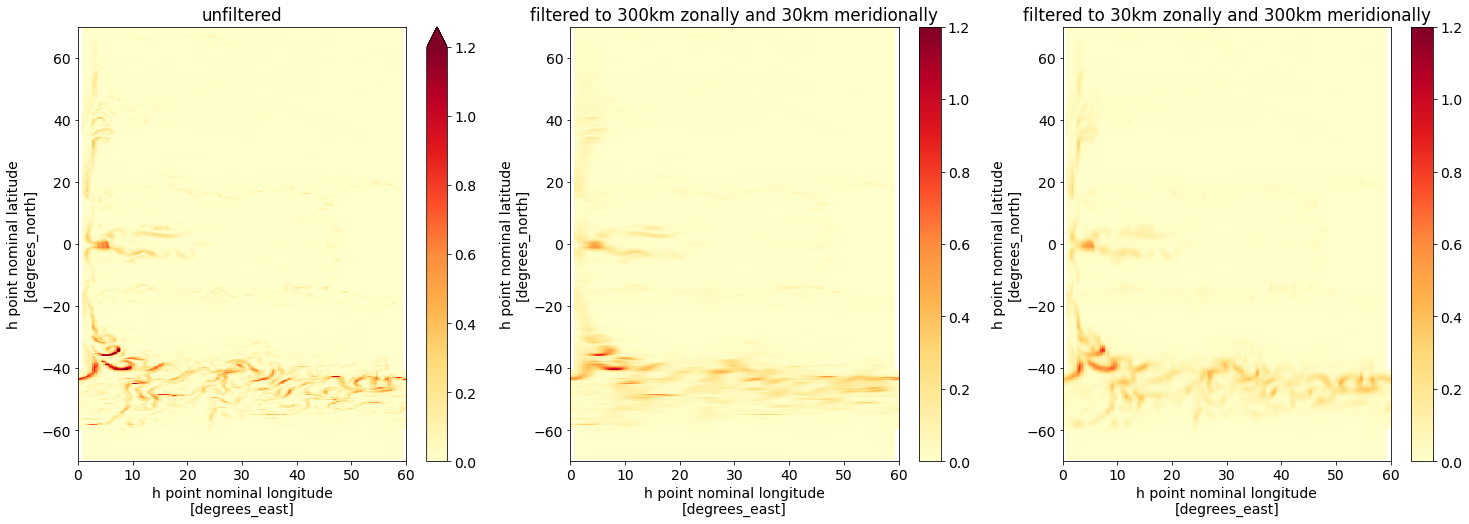

In [28]:
fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.KE.isel(time=time, zl=layer).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd', cbar_kwargs={'label': ''}
)
axs[0].set_title('unfiltered')

KE_filtered_aniso_y.isel(time=time, zl=layer).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd'
)
axs[1].set_title('filtered to 300km zonally and 30km meridionally')

KE_filtered_aniso_x.isel(time=time, zl=layer).plot(
    ax=axs[2], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd'
)
axs[2].set_title('filtered to 30km zonally and 300km meridionally');

The filtered fields show a clear zonally (middle) and meridionally (right) smooth structure.

## Filtering with a fixed factor 

In the next example, our goal is to use a filter that removes scales smaller than **10 times the local grid scale**. We call this filter type a *fixed factor filter*.
To achieve this, we will combine aspects from the previous 2 examples, and use a **spatially-varying & anisotropic filter**.

First, we need to know the maximum grid spacing.

In [29]:
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())
dx_max = dx_max.values
dx_max

array(27829.27492305)

We set our filter specs as follows.

In [30]:
filter_scale = 10 * dx_max
kappa_w = dxw * dxw / (dx_max * dx_max)
kappa_s = dys * dys / (dx_max * dx_max)

filter_fixed_factor = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)
filter_fixed_factor

Filter(filter_scale=278292.7492304958, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=33, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

Note that the number of required steps, `n_steps`, is 33. (Let's keep this number in mind for the next example.) But first, we filter kinetic energy as usual.

In [31]:
KE_filtered_fixed_factor = filter_fixed_factor.apply(ds.KE, dims=['yh', 'xh'])

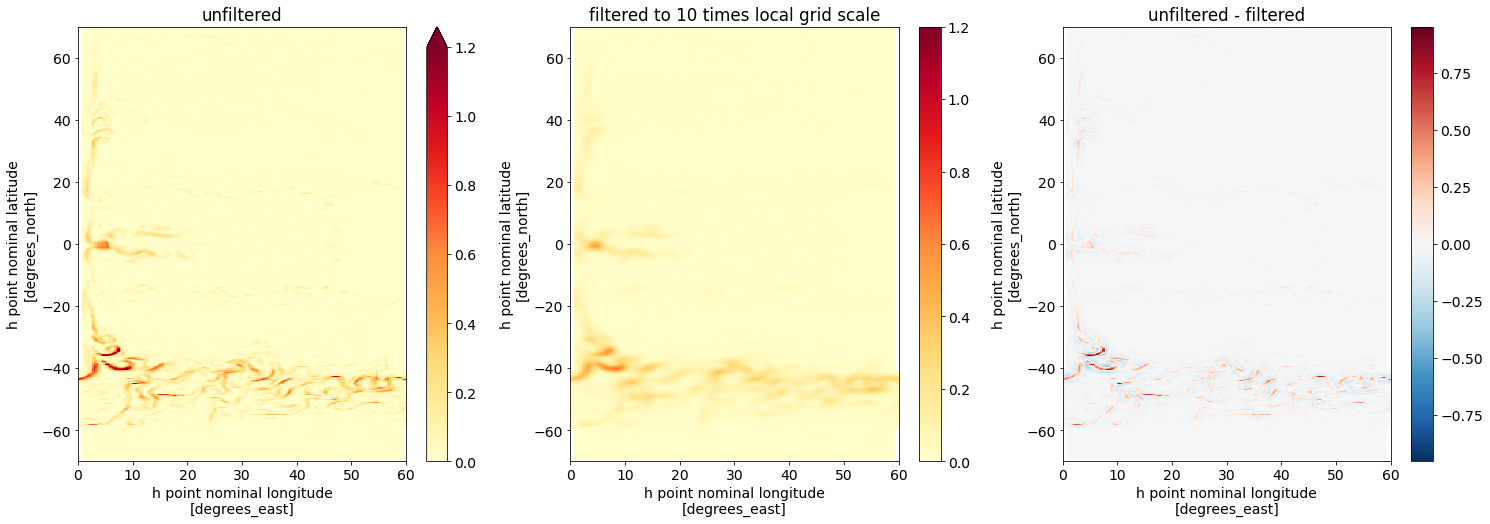

In [32]:
fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.KE.isel(time=time, zl=layer).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd', cbar_kwargs={'label': ''}
)
axs[0].set_title('unfiltered')

KE_filtered_fixed_factor.isel(time=time, zl=layer).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='YlOrRd'
)
axs[1].set_title('filtered to 10 times local grid scale')

(ds.KE - KE_filtered_fixed_factor).isel(time=time, zl=layer).plot(
    ax=axs[2], 
    cmap='RdBu_r'
)
axs[2].set_title('unfiltered - filtered');

With a fixed factor, we observe smoothing at both low and high latitudes.

### Simple fixed factor filter

In our final example, we use an **alternative method** to filter with a **fixed factor of 10**. It is more *ad hoc* than what we did in the previous example, but simpler and faster (especially if you filter large data sets). In [Grooms et al. (2021)](https://doi.org/10.1002/essoar.10506591.1) this filter is referred to as the **simple fixed factor filter**. The simple fixed factor filter works as follows:

1. **Before** filtering, **multiply the field by the local cell area**.
2. Apply filter with `dx_min=1` and `filter_scale=10`, pretending the grid was uniform.
3. **After** filtering, **divide** filtered field **by local cell area**.

In [33]:
filter_scale = 10
dx_min = 1

The actual filtering operation in the second step employs a Laplacian on a regular grid, for which we can use `REGULAR_WITH_LAND`. This Laplacian is more simple (and faster) and requires the following arguments.

In [34]:
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND)

['wet_mask']

We create our simple fixed factor filter.

In [35]:
filter_simple_fixed_factor = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_simple_fixed_factor

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.REGULAR_WITH_LAND: 2>)

The number of required steps, `n_steps`, is now only 11. (It was 33 in the previous example.) 

If we want to use the simple fixed factor filter, we need to filter the area-weighted field `KE` * `area`. 

In [36]:
KE_filtered_simple_fixed_factor = filter_simple_fixed_factor.apply(ds.KE * area, dims=['yh', 'xh'])

After filtering, we divide by the `area`.

In [37]:
KE_filtered_simple_fixed_factor = KE_filtered_simple_fixed_factor / area

Let's compare the result from the simple fixed factor filter with the more complex (and correct) fixed factor filter from the previous example.

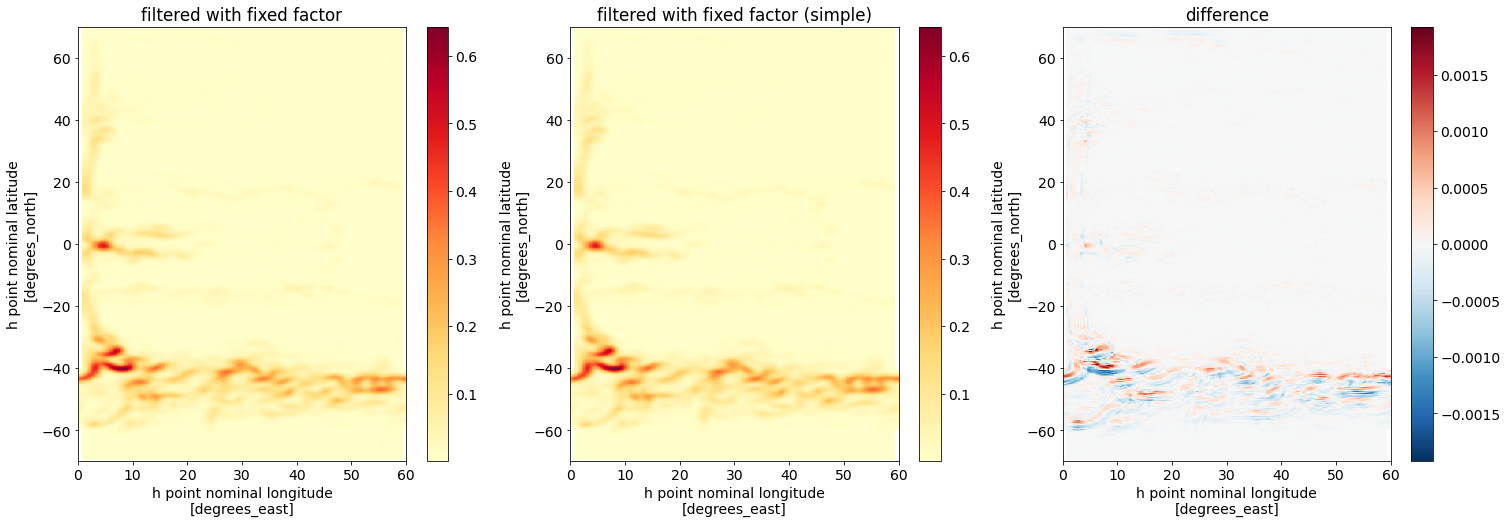

In [38]:
fig,axs = plt.subplots(1,3,figsize=(25,8))

KE_filtered_fixed_factor.isel(time=time, zl=layer).plot(ax=axs[0], cmap='YlOrRd')
axs[0].set_title('filtered with fixed factor')
KE_filtered_simple_fixed_factor.isel(time=time, zl=layer).plot(ax=axs[1], cmap='YlOrRd')
axs[1].set_title('filtered with fixed factor (simple)')
(KE_filtered_fixed_factor - KE_filtered_simple_fixed_factor).isel(time=time, zl=layer).plot(ax=axs[2])
axs[2].set_title('difference');

There are differences in the two filtered fields due to the simplicity of the simple fixed factor filter, but the differences are relatively small.